# Example of cross-domain classification with Deep Learning based methods
This is largely a copy of the `Cross-domain classification example.ipynb` notebook. The main difference is that this notebook makes use of deep learning based methods for solving the classification task at hand.

This notebooks shows an example of how the performance of machine learning algorithms is affected by shifts in the data distributions between training and evaluation. The machine learning scenario we are considering is *sentiment polarity* classification of product reviews: the task is to classify a given review as positive or negative towards the product that is reviewed. In this case, we have a *domain* shift: we see what happens if we evaluate a classifier trained on book reviews on a test set consisting of camera reviews, and vice versa.

> **Note** Training neural networks is computationally demanding and may take time if you run it on your laptop. Running the code in Google Colab will likely be faster and you can even get access to a GPU. We here assume that you are running this notebook in Google Colab, while running it on other computers with GPUs also works.

> **Note** To enable GPU hardware acceleration in Google Colab, click the `Change runtime type` field in the `runtime` drop-down menu, then choose `GPU` under hardware acceleration. One T4 GPU is sufficient for the computations in this notebook.

> **Note** If you are using Google Colab and you would like to export the notebook to HTML format, you need to first download it through `File` $\rightarrow$ `Download as` $\rightarrow$ `ipynb` and then use the standard tool for Jupyter Notebook conversion, nbconvert: jupyter nbconvert --to html notebook.ipynb (you need to run it from the command line). For more info (and example), see [here](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab).

## Required software

For this assignment you will need to install the following Python packages:

- `pytorch`: A deep learning framework that helps us define and train artificial neural networks. It provides automatic differentiation, GPU support, flexible composition of neural network models and numerous pre-defined network components and optimization methods. Installation instructions can be found on the [pytorch homepage](https://pytorch.org/get-started/locally/) (make sure that you install it together with CUDA to enable GPU acceleration). Documentation for the framework can be found [here](https://pytorch.org/docs/stable/index.html).
- `pandas`: Data analysis and manipulation tool.
- `tqdm`: Provides progress bars.
- `transformers`: Provides tools to easily download and train state-of-the-art pretrained models.
- `evaluate`: A library for easily evaluating machine learning models and datasets.
- `datasets`: A library for easily accessing and sharing datasets for Audio, Computer Vision, and Natural Language Processing (NLP) tasks.

> **Note** In Google Colab you can install packages using   `!pip  <package_name>`

> **Note** In Google Colab several of these packages are preinstalled but it is a good habit to check if all required packages are installed beforehand and the installed versions of packages. Use `!pip list` to list packages installed by pip on Google Colab.

In [1]:
!pip install torch pandas transformers evaluate datasets tqdm

We first import what's required.

In [2]:
# for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split

# for evaluating the quality of the classifier
import evaluate

# for loading and inspecting the data
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for running the DL based model
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, DistilBertForSequenceClassification, get_scheduler
from datasets import Dataset

## Data setup

The data we need can be downloaded [here](https://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip).

This is a processed version of the dataset used in the paper [Biographies, Bollywood, Boom-boxes and Blenders:
Domain Adaptation for Sentiment Classification](https://aclweb.org/anthology/P07-1056) by Blitzer et al., (2007). The original data was collected by [Mark Dredze](https://www.cs.jhu.edu/~mdredze/datasets/sentiment/).

The format in the file works is structured as in the following examples:
```
camera pos 857.txt i recently purchased this camera and i 'm loving it . as a whole it 's very easy to use
health neg 621.txt the brush completely feel apart prior to using it . i sent a review to the company
```
Each document is represented as one row in this text file. The first column stores the type of product that is reviewed: `books`, `camera`, `dvd`, `health`, `music`, or `software`. The value in the second columns represents the sentiment polarity of the review: positive (`pos`) or negative (`neg`). The third column is an identifier that we will ignore. The material after the third column is the review text. As you can see in the example, to make our life a bit easier the text has been preprocessed a bit: punctuation has been separated from the words, and all words have been converted into lowercase.

Now, let's write a function to read from this dataset. This function returns a list of documents `X` and their corresponding sentiment labels `Y`. We will only include documents that belong to a specificed product category.

In [3]:
!wget https://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip
!unzip dredze_amazon_reviews.zip

--2024-04-18 18:13:21--  https://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.222.93
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.222.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3480597 (3,3M) [application/zip]
Saving to: ‘dredze_amazon_reviews.zip’

dredze_amazon_revie 100%[===================>]   3,32M  1,44MB/s    in 2,3s    

2024-04-18 18:13:23 (1,44 MB/s) - ‘dredze_amazon_reviews.zip’ saved [3480597/3480597]

Archive:  dredze_amazon_reviews.zip
  inflating: dredze_amazon_reviews.txt  


In [4]:
def read_documents_product(doc_file, product):

    # will store the documents
    X = []

    # will store the sentiment labels
    Y = []

    # open the file, force utf-8 encoding if this isn't the default on your system
    with open(doc_file, encoding='utf-8') as f:

        # read the file line by line
        for line in f:

            # split the line into the four parts mentioned above
            p, s, _, d = line.strip().split(maxsplit=3)

            # if this document belongs to the category we're interested in...
            if p == product:

                # then add the document and its label to the respective lists
                X.append(d)
                Y.append(s)

    return X, Y

We read the book reviews and camera reviews.

In [5]:
Xbooks, Ybooks = read_documents_product('dredze_amazon_reviews.txt', 'books')
Xcam, Ycam = read_documents_product('dredze_amazon_reviews.txt', 'camera')

We split the book data and camera data into training and test sets. We use 20% of the data for testing. The `random_state` argument here is for reproducibility, to make sure we get the same train/test split each time we run the notebook, since `train_test_split` does the split randomly.

In [6]:
Xb_train, Xb_eval, Yb_train, Yb_eval = train_test_split(Xbooks, Ybooks, test_size=0.2, random_state=12345)
Xc_train, Xc_eval, Yc_train, Yc_eval = train_test_split(Xcam, Ycam, test_size=0.2, random_state=12345)

## Model setup
We are now ready to define and train our deep learning based model. We will make use of the pretrained [DistilBERT base uncased](https://huggingface.co/distilbert/distilbert-base-uncased) model with 66M trainable parameters. It was developed by [Sanh et al.](https://arxiv.org/pdf/1910.01108.pdf) and is a lighter version of the common [BERT](https://arxiv.org/pdf/1810.04805.pdf) (Bidirectional Encoder Representations from Transformers) model (with 110M parameters). Like BERT, DistilBERT computes contextualized representations of text that are useful for solving different tasks.

Even though DistilBERT has been optimized for lightness, it is a large neural network that requires pretraining and needs to be run on a GPU. It makes use of Transformers and Attention to process text. This model is more advanced compared to e.g. RNNs or word counting and represents a light version of state-of-the-art (SOTA) models for text classification.

The "true" SOTA model for text classification is something like [RoBERTa-large cased](https://huggingface.co/FacebookAI/roberta-large) with 355M parameters. Due to its sheer size, we will not consider the RoBERTa model in this example.

### Tokenizer
The tokenizer makes out an important part of each DL based models. Text is non-euclidian, and to convert this to something computers can process (=numbers), tokenization and word embeddings are typically used. Usually, each NLP model comes with its own tokenizer that was used to pretrain it. Tokenizers can be implemented in several different ways, but they all have in common that they transform text into subparts (tokens) assigned unique numbers. They can then be mapped to pre-trained word embeddings that aim to represent the "meaning" of each word as a multi-dimensional vector.

More information on how tokenizers are implemented can be found on the [Huggingface website](https://huggingface.co/docs/transformers/main_classes/tokenizer).

We import the tokenizer for DistilBERT below.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Below, we print some examples to illustrate the workings of tokenizers. As you can see, the tokenizer always prepends a `[CLS]` and appends a `[SEP]` token to each input. Model representations for these tokens can later be used for different tasks. We will make use of the `[CLS]` token for our classification task.

In [8]:
token_ids = tokenizer.encode("This book by Perriwinkle is awesome!")
print(token_ids)
tokens = [tokenizer.decode(val, clean_up_tokenization_spaces=True) for val in token_ids]
print(tokens)
print()

token_ids = tokenizer.encode("I would say that the previous book in this series 'A song of ice and fire' is better.")
print(token_ids)
tokens = [tokenizer.decode(val) for val in token_ids]
print(tokens)

[101, 2023, 2338, 2011, 2566, 3089, 10105, 19099, 2003, 12476, 999, 102]
['[CLS]', 'this', 'book', 'by', 'per', '##ri', '##win', '##kle', 'is', 'awesome', '!', '[SEP]']

[101, 1045, 2052, 2360, 2008, 1996, 3025, 2338, 1999, 2023, 2186, 1005, 1037, 2299, 1997, 3256, 1998, 2543, 1005, 2003, 2488, 1012, 102]
['[CLS]', 'i', 'would', 'say', 'that', 'the', 'previous', 'book', 'in', 'this', 'series', "'", 'a', 'song', 'of', 'ice', 'and', 'fire', "'", 'is', 'better', '.', '[SEP]']


To be able to train and evaluate our DistilBERT model, we first need to reformat our data. We transform the labels to numbers, tokenize all datasets and implement data loaders for these. Data loaders are necessary as the computational load would be too heavy if we cram in all 16000 train samples at once into the model. Instead, the data is processed in _batches_ of 32 samples at a time.

In [9]:
label_to_int = {"neg": 0, "pos": 1}
int_to_label = {0: "neg", 1: "pos"}
batch_size = 32

def tokenize_function(examples):
    tokenized_batch = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokenized_batch["label"] = [label_to_int[label] for label in examples["label"]]
    return tokenized_batch

book_train_dataset = Dataset.from_dict({"text": Xb_train, "label": Yb_train}, split="train")
book_eval_dataset = Dataset.from_dict({"text": Xb_eval, "label": Yb_eval}, split="eval")
camera_eval_dataset = Dataset.from_dict({"text": Xc_eval, "label": Yc_eval}, split="eval")

tokenized_book_train_dataset = book_train_dataset.map(tokenize_function, batched=True).remove_columns(["text"]).rename_column("label", "labels")
tokenized_book_eval_dataset = book_eval_dataset.map(tokenize_function, batched=True).remove_columns(["text"]).rename_column("label", "labels")
tokenized_camera_eval_dataset = camera_eval_dataset.map(tokenize_function, batched=True).remove_columns(["text"]).rename_column("label", "labels")

tokenized_book_train_dataset.set_format("torch")
tokenized_book_eval_dataset.set_format("torch")
tokenized_camera_eval_dataset.set_format("torch")

train_dataloader = DataLoader(tokenized_book_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_book_eval_dataset, batch_size=batch_size)
camera_eval_dataloader = DataLoader(tokenized_camera_eval_dataset, batch_size=batch_size)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Below, you can see an example of the processed training data.

In [10]:
print(Xb_train[0])
print(tokenized_book_train_dataset[0])

i have not been able to put this book down since i received it . i have always dreamed of visiting italy , but until that time comes , i have been redecorating my home to reflect that dream . i now have a " tuscan kitchen " that makes me very happy to be in . i bought this book for new ideas , and also to confirm that the elements in my home already are the correct ones . i was thrilled to find these " tuscan elements " such as pottery , stones , tiles discussed throughout . and the photographs inspire me to pay attention to details . it 's all about the textures of the walls , the colors , how you display your ceramics....the pictures are beautiful . i may not get to italy any time soon , but this book helped bring my dream a little closer to home
{'labels': tensor(1), 'input_ids': tensor([  101,  1045,  2031,  2025,  2042,  2583,  2000,  2404,  2023,  2338,
         2091,  2144,  1045,  2363,  2009,  1012,  1045,  2031,  2467, 13830,
         1997,  5873,  3304,  1010,  2021,  2127, 

One important limitation of models based on Transformers is that they can only process inputs up to a maximum length due to performance issues. Dissimilarly to RNNs, these models do not process the input recursively, but all at once and up to a maximum input length. A maximum input length has to be defined as the computational cost of the Transformer scales quadtratically with the input length. This is a current issue for most NLP models and has up to this point no definitive solution.

DistilBERT has a maximum input size of 512 and the tokenizer has truncated all samples to this length. The reviews samples do not generally contain more than 512 words, while these words also can be split into several tokens.

Max input length: 512


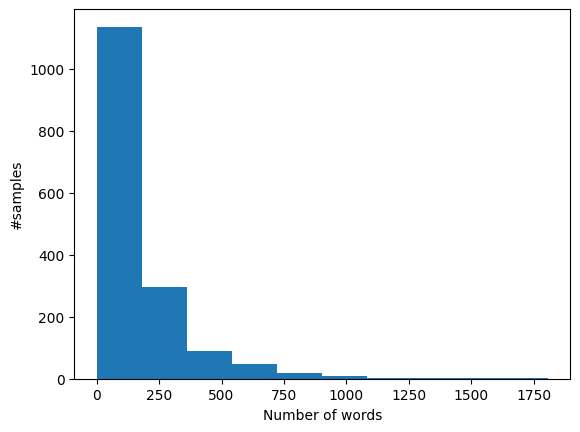

In [11]:
print(f"Max input length: {len(tokenized_book_train_dataset[0]['input_ids'])}")
plt.hist([len(val.split()) for val in Xb_train])
plt.xlabel("Number of words")
plt.ylabel("#samples")
plt.show()

### Model

We are now ready to define and train our DistilBERT model. For this we make use of the Transformers package that loads the model with the pretrained weights and adds a linear classification layer that processes the model representation for the `[CLS]` token to make a prediction. The code for this implementation can be found [here](https://huggingface.co/transformers/v3.0.2/_modules/transformers/modeling_distilbert.html#DistilBertForSequenceClassification).

We could implement this ourselves, but make use of the Huggingface package for simplicity.

The model is an instance of a [PyTorch module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Below, you can view its full architecture in a printed format.

In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Similarly to the case for all neural nets, we train the model using stochastic gradient descent and therefore need to define a optimizer to guide this process.

We also define a learning rate scheduler that linearly decreases the lr as the model training progresses.

In [13]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

To train the model on our GPU (if we have one), we need to move the model to the corresponding device.

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Training
We are now ready to take on the most computationally heavy part of this example. We first define an evaluation function to be used during training and after.

In [15]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def evaluate_model(model, dataloader):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            preds.extend(predictions.detach().tolist())
            accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
            f1_metric.add_batch(predictions=predictions, references=batch["labels"])

    result = {"accuracy": accuracy_metric.compute()["accuracy"], "f1": f1_metric.compute(average=None)["f1"]}
    model.train()
    return result, preds

We can now train our DistilBERT model.

In [16]:
progress_bar = tqdm(range(num_training_steps))
steps_between_eval = int(num_training_steps/10)

model.train()
num_steps = 0
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        num_steps += 1

        if num_steps % steps_between_eval == 0:
            result, _ = evaluate_model(model, eval_dataloader)
            tqdm.write(f"Step {num_steps}")
            tqdm.write(f"\tTrain loss: {loss}")
            tqdm.write(f"\tEvaluation scores: {result}")

  0%|          | 0/100 [00:00<?, ?it/s]

Step 10
	Train loss: 0.6540060639381409
	Evaluation scores: {'accuracy': 0.8575, 'f1': array([0.85117493, 0.86330935])}
Step 20
	Train loss: 0.5026053786277771
	Evaluation scores: {'accuracy': 0.88, 'f1': array([0.87368421, 0.88571429])}
Step 30
	Train loss: 0.17949837446212769
	Evaluation scores: {'accuracy': 0.84, 'f1': array([0.80606061, 0.86382979])}
Step 40
	Train loss: 0.3203667998313904
	Evaluation scores: {'accuracy': 0.8975, 'f1': array([0.89124668, 0.90307329])}
Step 50
	Train loss: 0.33706656098365784
	Evaluation scores: {'accuracy': 0.9, 'f1': array([0.90049751, 0.89949749])}
Step 60
	Train loss: 0.22406034171581268
	Evaluation scores: {'accuracy': 0.9075, 'f1': array([0.9038961 , 0.91084337])}
Step 70
	Train loss: 0.22755545377731323
	Evaluation scores: {'accuracy': 0.9075, 'f1': array([0.90537084, 0.90953545])}
Step 80
	Train loss: 0.057019904255867004
	Evaluation scores: {'accuracy': 0.9125, 'f1': array([0.91048593, 0.91442543])}
Step 90
	Train loss: 0.2876208424568176
	

After training the model, we can evaluate its performance on the different datasets.

### Evaluate on the book dataset
We start by evaluating on the in-domain dataset that best matches the training data. We can observe how the DistilBERT model reaches an accuracy of about 0.91 on this dataset, which can be compared to the accuracy of about 0.8 for the LinearSVC in the original example.

In [17]:
book_result, book_preds = evaluate_model(model, eval_dataloader)
print(book_result)

{'accuracy': 0.915, 'f1': array([0.91414141, 0.91584158])}


### Error cases

In [18]:
book_results = pd.DataFrame({"gold": Yb_eval, "pred": [int_to_label[pred] for pred in book_preds], "text": Xb_eval})
pd.set_option('max_colwidth', 400)
book_results[~(book_results.gold==book_results.pred)]

,gold,pred,text
16,neg,pos,"i have introduced many of my ell , high school students to lois lowery and the depth of her characters . she is a brilliant writer and capable of inspiring fierce passion in her readers as they encounter shocking details of her utopian worlds . i was anxious to read this companion novel and had planned to share it with my class this january . although the series is written for 6th graders and ..."
32,neg,pos,"the best out of three guide books i looked at , and a must for the first trip to the big island ."
36,pos,neg,it 's a beu
40,pos,neg,"americans who ca n't name five poets will name allen ginsberg . in this case , that is good since he was one of america 's greatest poets . this book attest to this . i write this review to show disappointment in the publisher who continues to publish the collected works on the cheapest paper next to newsprint . for the next edition , i would like to see , at least in limited edition , a volum..."
52,neg,pos,"investment banker with a conscience , ben hartman , and special agent anna navaro 's plot lines and bodies soon become intertwined in their quest for the secrets of sigma , an elite cabal with roots in nazi germany that is bent on world domination . what starts out as reasonable and entrancing enough genre pulp becomes sheer bond by the end , but there 's no denying ludlum has a gift for keepi..."
53,neg,pos,"save yourself time and buy any book by greg lemond ( greg lemond 's complete book of bicycling ) or john howard ( john howard 's the cyclist 's companion ) - - they are both far better writers , well-rounded bicyclists , and honorable family men - - good role models for all true cycling athletes , young and old alike . lance armstrong is good at chronicling his many bicycling events and achiev..."
59,pos,neg,"the book and accompanying dvd are being used in a class i am taking on photoshop elements 4. both of them make it much easier to understand what 4 is capable of and how to use the program , especially the tools . without instruction , complimented by 1 on 1 , i would not be able to use even a small percentage of the power of 4. 1 on 1 goes step by step in 12 chapters of "" how to "" fix , enhanc..."
130,pos,neg,"deyoung begins by relating how bush pushed powell out at the end of his 1st term , without the courtesy of even personally discussing it with him ; making matters worse was the fact that bush did n't even know why powell was at the white house when it came time to say "" good bye . "" colin powell came from jamaican parents ( often called "" jewmaicans "" by american negroes because of the emphasi..."
146,pos,neg,"the book uses cartoons to emphasize the text . it 's always interesting to see what common words different cultures use to describe the human condition . wastes a lot of space , though . worth the price"
162,pos,neg,"...in the beginnig of the 1930 's , the turks would have succeeded in making the whole world forget about the armenian genocide that took place in 1915 / 16. turkey did succeed in putting pressure on the us-government in 1933 though , when a movie was supposed to be made based on this book , so the then us-government again put pressure on mgm not to make this movie . a foreign government coerc..."


### Evaluate on the camera dataset
We continue by evaluating on the slightly out-of-domain camera dataset. We can observe how the DistilBERT model reaches an accuracy of about 0.85-0.89 on this dataset, which can be compared to the accuracy of about 0.75 for the LinearSVC in the original example.

In [19]:
camera_result, camera_preds = evaluate_model(model, camera_eval_dataloader)
print(camera_result)

{'accuracy': 0.885, 'f1': array([0.89201878, 0.87700535])}


### Error cases

In [20]:
camera_results = pd.DataFrame({"gold": Yc_eval, "pred": [int_to_label[pred] for pred in camera_preds], "text": Xc_eval})
pd.set_option('max_colwidth', 400)
camera_results[~(camera_results.gold==camera_results.pred)]

,gold,pred,text
10,pos,neg,"this item worked , allowed me to use printer and docking station from another kodak camera . would do it agai"
11,pos,neg,"this tripod arrived on time and in good condition . however i have to put the "" heavy duty "" in quotations as this item is for amateurs mostly and is made of plastic as well . the weight you can put on it is limited . however it does the job well for the amateur photographer or videographer"
15,neg,pos,"i was looking for a pair of roof-prism binoculars like this , for hawk and bird watching . i had looked at swarovskis , but they were way out of my budget , nearly a thousand dollars for this resolution . these binoculars are crystal-clear , with sharp focus . the 42mm lens lets in lots of light , lots more than the 35 's i 've been using . i wear glasses and the twist - up - and -down eyecups..."
24,neg,pos,"i 've just returned this unit . it does n't play videos as advertised . i was able to get it to properly play .avi files at 320 x 240 resolution...see other review below . but 320x240 gives a postage stamp size picture . at 640 x 480 the playback was full size but jerky and broken....more later . i have now had 3 different brands of 8 "" photo frames in my possession : a phillips , a pandigital..."
43,pos,neg,"i have used this charger & battery package for a while now in my digital slr , battery performance is excellent ! the downside is that the charger has issues : the top bay charges faster than the bottom bay and the batteries get very hot when charging , it has not seemed to affect the batteries in the year i have had them . if you are looking for exceptional batteries buy these , and the charg..."
60,pos,neg,"installing the software was a piece of cake , using it is quite another matter . the basic introductory instructions are easy enough but after that it seems to require a phd in mathematic astrophysics to get round all the available toggles , tweaks and options . first attempts ? the moon came out real nice , but saturn was a white blob with no fine detail . nothing like type of pics that the s..."
67,pos,neg,"i had been waiting 3 years for any manufacturer to market a camera similar in specification to the canon eos1. as exploration health , safety & environment advisor , work takes me to middle of the desert or the oceans . the wait was for 35mm film quality , with speed of picture taking ( 5 frames per second is barely enough to capture dolphins - hence the 8 + fps of the eos 1 was desired ) . th..."
68,pos,neg,"after researching several cameras in this price range , i bought the rebel t2 last month . it has met my expectations and perhaps then some . after recently trying out a friends camera in the 150.-ish range , i partially regret spending what i did . it all comes down to what you need , want , and how many bells and whistles you like . for the money though , compared to the competitors , i stil..."
77,pos,neg,"-this camara picture quality is nice , and depend on user purpose . my gf is kinda satify with it . -function is easy to use . -battery life is so so . -battery charger design is not convenience . you have the put the battery into the batter charger . recommand to get a cradle charger , but extra cost . it should sell with cradle charger ."
98,pos,neg,"if you 're looking for a high-quality telephoto zoom lens that is fast enough to use indoors , you may have found what you 're looking for . the 70-200 / 2.8 lens produces beautiful results that are overall on par with the 135 / 2 prime lens ( although not quite as sharp ) . the main downside to this lens is that it 's big and heavy . i do n't mind carrying it around my neck on the camera so m..."
